In [26]:
import numpy as np
import pandas as pd
import matplotlib
import re

In [34]:
data = np.genfromtxt('./historical-hourly-weather-data/temperature.csv', delimiter=',', names=True)
data = pd.read_csv('./historical-hourly-weather-data/temperature.csv')

In [36]:
data[['datetime', 'Montreal']].to_csv('./montreal-temperature2012-2017.csv')

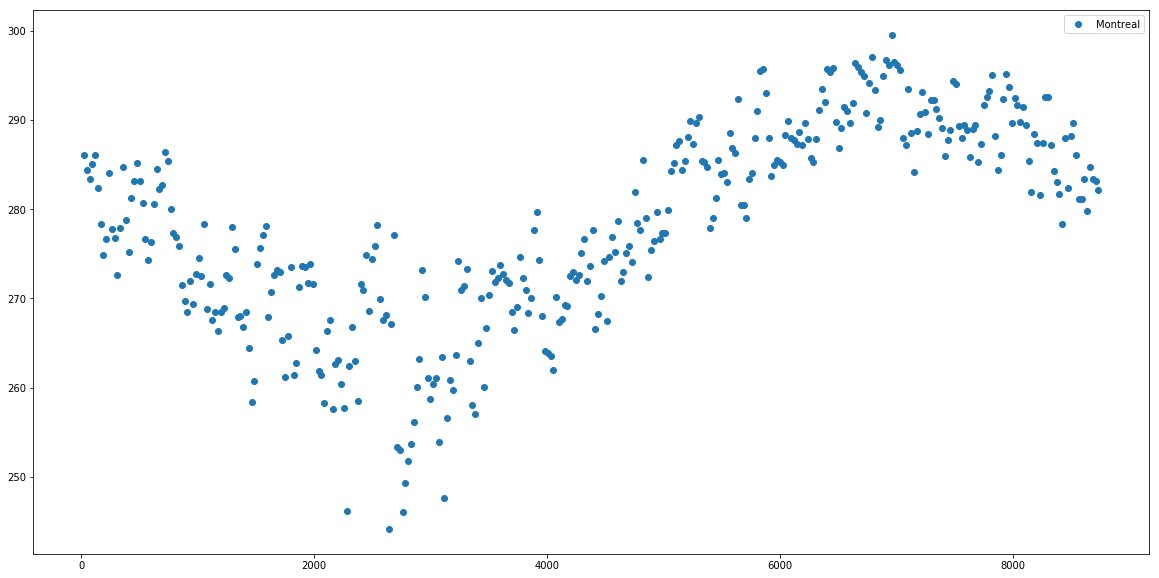

In [37]:
data[['datetime', 'Montreal']][0:24*365:24].plot(style=['o','rx'], figsize=(20, 10))

In [38]:
def get_data(file):
    data = []
    with open(file) as f:
        lines = f.readlines()[2:]
        for line in lines:
            tokens = line.split(',')
            tokens = [tokens[0], tokens[26]]
            tokens = re.findall(r"[\w']+", tokens[0])[:-2] + tokens[1:]
            if tokens[-1] != '':
                data.append(tokens)
    print(data)
    return data

data = get_data('./historical-hourly-weather-data/temperature.csv')

[['2012', '10', '01', '13', '286.26'], ['2012', '10', '01', '14', '286.262540958'], ['2012', '10', '01', '15', '286.269518418'], ['2012', '10', '01', '16', '286.276495879'], ['2012', '10', '01', '17', '286.283473339'], ['2012', '10', '01', '18', '286.290450799'], ['2012', '10', '01', '19', '286.297428259'], ['2012', '10', '01', '20', '286.304405719'], ['2012', '10', '01', '21', '286.311383179'], ['2012', '10', '01', '22', '286.318360639'], ['2012', '10', '01', '23', '286.325338099'], ['2012', '10', '02', '00', '286.332315559'], ['2012', '10', '02', '01', '286.339293019'], ['2012', '10', '02', '02', '286.346270479'], ['2012', '10', '02', '03', '286.353247939'], ['2012', '10', '02', '04', '286.360225399'], ['2012', '10', '02', '05', '286.367202859'], ['2012', '10', '02', '06', '286.374180319'], ['2012', '10', '02', '07', '286.38115778'], ['2012', '10', '02', '08', '286.38813524'], ['2012', '10', '02', '09', '286.3951127'], ['2012', '10', '02', '10', '286.40209016'], ['2012', '10', '02', 

In [39]:
def normalize_x(line):
    line[0] = float(line[0]) / 5000
    line[1] = (float(line[1]) - 1) / 12
    line[2] = (float(line[2]) - 1) / 31
    line[3] = float(line[3]) / 24
    return line

def normalize_y(temp):
    temp = float(temp) / 350
    return temp

def normalize_data(data):
    new_data = []
    for line in data:
        x = line[:-1]
        y = line[-1]
        new_data.append(normalize_x(x) + [normalize_y(y)])
    return new_data

new_data = normalize_data(data)

In [40]:
import pandas
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(64, input_dim=4, kernel_initializer='normal', activation='relu'))
    model.add(Dense(32, input_dim=4, kernel_initializer='normal', activation='relu'))
    model.add(Dense(16, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [41]:
X = np.array([line[:-1] for line in new_data])
Y = np.array([line[-1] for line in new_data])

In [42]:
model = baseline_model()

model.fit(X, Y, epochs=5, batch_size=100)

model.save('model.h5')

Epoch 1/5
45252/45252 [==============================] - 33s 727us/step - loss: 0.0592
Epoch 2/5
45252/45252 [==============================] - 31s 694us/step - loss: 6.2288e-04
Epoch 3/5
45252/45252 [==============================] - 32s 716us/step - loss: 2.5146e-04
Epoch 4/5
45252/45252 [==============================] - 33s 723us/step - loss: 2.2337e-04
Epoch 5/5
45252/45252 [==============================] - 32s 699us/step - loss: 2.2042e-04


In [43]:
print(model.evaluate(X, Y))

45252/45252 [==============================] - 12s 275us/step
0.00021402979206218157


In [45]:
data_x = X[-1].reshape((4, 1))
print(data_x.shape)
model.predict(data_x.reshape((1, 4)))[0] * 350

(4, 1)


array([278.20132], dtype=float32)

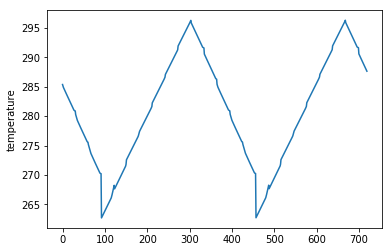

In [46]:
import matplotlib.pyplot as plt

plt.plot((model.predict(X) * 350)[:720*24:24])
plt.ylabel('temperature')
plt.show()

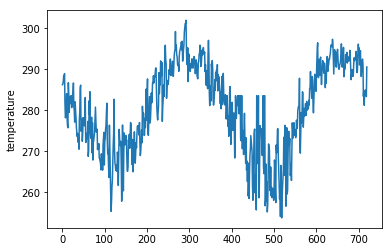

In [47]:
import matplotlib.pyplot as plt
import matplotlib

plt.plot((Y * 350)[:720*24:24])
plt.ylabel('temperature')
plt.show()

In [70]:
data_x = []
data_orig = []
for day in range(1, 32):
    for hour in range(0, 24):
        data_orig.append("%4d-%02d-%02d %02d:00:00" % (2017, 12, day, hour))
        data_x.append(normalize_x([str(2017),  str(12), str(day), str(hour)]))
days = {1: 31, 2: 28, 3: 31, 4: 30, 5: 31, 6: 30, 7: 31, 8: 31, 9: 30, 10: 31, 11: 30, 12: 31}
for month in range(1, 13):
    for day in range(1, days[month] + 1):
        for hour in range(0, 24):
            data_orig.append("%4d-%02d-%02d %02d:00:00" % (2018, month, day, hour))
            data_x.append(normalize_x([str(2018),  str(month), str(day), str(hour)]))
data_x
data_x = np.array(data_x)
data_y = model.predict(data_x) * 350
n = len(data_y)

In [72]:
new_csv = np.append(np.array(data_orig).reshape(n, 1), data_y, axis=1)

In [153]:
import pandas as pd
df=pd.read_csv('./montreal-temperature2012-2017.csv', sep=',',header=1)
arr = df.values[:,1:]

In [154]:
arr

array([['2012-10-01 13:00:00', 285.83],
       ['2012-10-01 14:00:00', 285.834649953],
       ['2012-10-01 15:00:00', 285.847789539],
       ...,
       ['2017-11-29 22:00:00', 273.48],
       ['2017-11-29 23:00:00', 272.48],
       ['2017-11-30 00:00:00', 271.8]], dtype=object)

In [155]:
arr.shape

(45252, 2)

In [156]:
new_csv.shape

(9504, 2)

In [158]:
sol = np.append(arr, new, axis = 0)

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [137]:
sol.shape

(54756, 3)

In [138]:
len(new_arr)

9504

In [139]:
len(new_csv)

9504

In [140]:
len(arr)

45252

In [141]:
len(arr) + len(new_csv)

54756

In [147]:
import pandas as pd 
df = pd.DataFrame(sol)
df.to_csv("montreal-2012-2018.csv")